# MaldiAMRKit - Evaluation & Splitting

This notebook covers AMR-specific evaluation metrics, stratified splitting
utilities, and integration with scikit-learn's cross-validation tools.

## Import Libraries

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from maldiamrkit import MaldiSet
from maldiamrkit.evaluation import (
    CaseGroupedKFold,
    LabelEncoder,
    SpeciesDrugStratifiedKFold,
    amr_classification_report,
    case_based_split,
    categorical_agreement,
    major_error_rate,
    me_scorer,
    sensitivity_score,
    specificity_score,
    stratified_species_drug_split,
    very_major_error_rate,
    vme_me_curve,
    vme_scorer,
)

## AMR Evaluation Metrics

In clinical antimicrobial resistance testing, standard ML metrics (accuracy,
F1) do not capture the clinical severity of errors. MaldiAMRKit provides
domain-specific metrics following EUCAST/CLSI conventions:

- **VME (Very Major Error)**: resistant isolate called susceptible - the most
  dangerous error (could lead to treatment failure)
- **ME (Major Error)**: susceptible isolate called resistant - wasteful but
  not immediately dangerous
- **Sensitivity**: TP / (TP + FN) = 1 - VME
- **Specificity**: TN / (TN + FP) = 1 - ME
- **Categorical Agreement**: overall accuracy (TP + TN) / N

In [2]:
# Simulated predictions: 1 = resistant, 0 = susceptible
y_true = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0])
y_pred = np.array([1, 1, 0, 1, 0, 0, 1, 0, 0, 0])

# Very Major Error: 1 out of 4 resistant samples was missed
vme = very_major_error_rate(y_true, y_pred)
print(f"VME (Very Major Error):   {vme:.2%}")

# Major Error: 1 out of 6 susceptible samples was falsely called resistant
me = major_error_rate(y_true, y_pred)
print(f"ME (Major Error):         {me:.2%}")

# Sensitivity and specificity
print(f"Sensitivity:              {sensitivity_score(y_true, y_pred):.2%}")
print(f"Specificity:              {specificity_score(y_true, y_pred):.2%}")

# Categorical agreement
print(f"Categorical Agreement:    {categorical_agreement(y_true, y_pred):.2%}")

VME (Very Major Error):   25.00%
ME (Major Error):         16.67%
Sensitivity:              75.00%
Specificity:              83.33%
Categorical Agreement:    80.00%


### AMR Classification Report

Get all metrics in a single dictionary with `amr_classification_report`.

In [3]:
report = amr_classification_report(y_true, y_pred)
for key, value in report.items():
    if isinstance(value, float):
        print(f"  {key:>25s}: {value:.4f}")
    else:
        print(f"  {key:>25s}: {value}")

                        vme: 0.2500
                         me: 0.1667
                sensitivity: 0.7500
                specificity: 0.8333
      categorical_agreement: 0.8000
                n_resistant: 4
              n_susceptible: 6
                    n_total: 10


### VME/ME Trade-off Curve

The `vme_me_curve` function computes VME and ME rates at varying decision
thresholds. This is analogous to an ROC curve but uses clinically meaningful
error types.

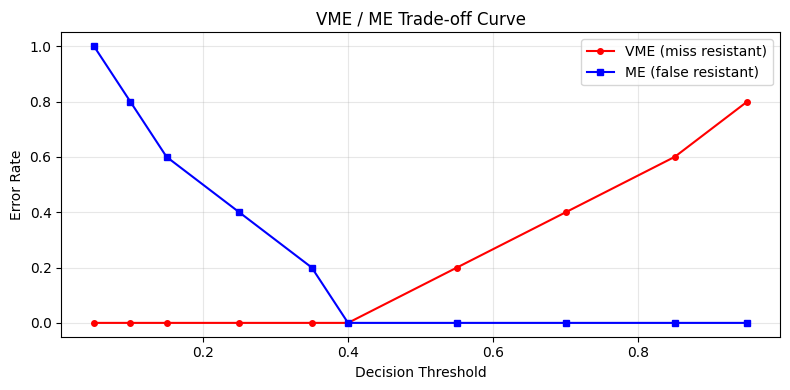

In [4]:
import matplotlib.pyplot as plt

# Simulated probability scores
y_true_curve = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
y_scores = np.array([0.95, 0.85, 0.70, 0.55, 0.40, 0.35, 0.25, 0.15, 0.10, 0.05])

vme_rates, me_rates, thresholds = vme_me_curve(y_true_curve, y_scores)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(thresholds, vme_rates, "r-o", label="VME (miss resistant)", markersize=4)
ax.plot(thresholds, me_rates, "b-s", label="ME (false resistant)", markersize=4)
ax.set_xlabel("Decision Threshold")
ax.set_ylabel("Error Rate")
ax.set_title("VME / ME Trade-off Curve")
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Splitting Utilities

Standard random splitting can cause data leakage or imbalanced species
representation. MaldiAMRKit provides:

- **`stratified_species_drug_split`**: stratified train/test split preserving
  species-drug label distributions
- **`case_based_split`**: keeps all samples from the same patient in the same
  split to prevent leakage

### Load Real Data

In [5]:
data = MaldiSet.from_directory(
    "../data/",
    "../data/metadata/metadata.csv",
    aggregate_by=dict(antibiotics="Drug"),
)
X = data.X
y_raw = data.y["Drug"].values
species = data.meta["Species"].values

enc = LabelEncoder()
y = enc.fit_transform(y_raw)

print(f"X shape: {X.shape}")
print(f"Labels: {np.unique(y_raw, return_counts=True)}")
print(f"Species: {np.unique(species, return_counts=True)}")

X shape: (29, 6000)
Labels: (array(['R', 'S'], dtype=object), array([10, 19]))
Species: (array(['taxon'], dtype=object), array([29]))


### Stratified Species-Drug Split

In [6]:
X_train, X_test, y_train, y_test = stratified_species_drug_split(
    X, y, species, test_size=0.2, random_state=42
)

print(f"Train: {len(X_train)} samples, Test: {len(X_test)} samples")
print(f"Train R-S: {y_train.sum():.0f}R - {len(y_train) - y_train.sum():.0f}S")
print(f"Test  R-S: {y_test.sum():.0f}R - {len(y_test) - y_test.sum():.0f}S")

Train: 23 samples, Test: 6 samples
Train R-S: 8R - 15S
Test  R-S: 2R - 4S


### Case-Based Split

In clinical data, multiple spectra may come from the same patient.
`case_based_split` ensures no patient appears in both train and test sets.

Since our sample data does not include patient IDs, we simulate them here.

In [7]:
# Simulate case IDs (roughly 3 spectra per patient)
case_ids = np.array([f"patient_{i // 3}" for i in range(len(X))])

X_train_c, X_test_c, y_train_c, y_test_c = case_based_split(
    X, y, case_ids, test_size=0.3, random_state=42
)

# Verify no patient leakage using positional indices
train_pos = X.index.get_indexer(X_train_c.index)
test_pos = X.index.get_indexer(X_test_c.index)
train_patients = set(case_ids[train_pos])
test_patients = set(case_ids[test_pos])
print(f"Train: {len(X_train_c)} samples ({len(train_patients)} patients)")
print(f"Test:  {len(X_test_c)} samples ({len(test_patients)} patients)")
print(f"Patient overlap: {len(train_patients & test_patients)} (should be 0)")

Train: 20 samples (7 patients)
Test:  9 samples (3 patients)
Patient overlap: 0 (should be 0)


## Cross-Validation Splitters

MaldiAMRKit provides sklearn-compatible CV splitters for use with
`cross_val_score`, `GridSearchCV`, etc.

- **`SpeciesDrugStratifiedKFold`**: stratified by species-drug combinations
- **`CaseGroupedKFold`**: grouped by patient/case ID

In [8]:
# Species-drug stratified K-fold cross-validation
cv_stratified = SpeciesDrugStratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("SpeciesDrugStratifiedKFold folds:")
for i, (train_idx, test_idx) in enumerate(
    cv_stratified.split(X.values, y, species=species)
):
    print(
        f"  Fold {i + 1}: train={len(train_idx)}, test={len(test_idx)}, "
        f"test R%={y[test_idx].mean():.1%}"
    )

SpeciesDrugStratifiedKFold folds:
  Fold 1: train=19, test=10, test R%=30.0%
  Fold 2: train=19, test=10, test R%=40.0%
  Fold 3: train=20, test=9, test R%=33.3%


In [9]:
# Case-grouped K-fold (no patient leakage between folds)
cv_grouped = CaseGroupedKFold(n_splits=3)

print("CaseGroupedKFold folds:")
for i, (train_idx, test_idx) in enumerate(
    cv_grouped.split(X.values, y, groups=case_ids)
):
    train_cases = set(case_ids[train_idx])
    test_cases = set(case_ids[test_idx])
    print(
        f"  Fold {i + 1}: train={len(train_idx)}, test={len(test_idx)}, "
        f"overlap={len(train_cases & test_cases)}"
    )

CaseGroupedKFold folds:
  Fold 1: train=18, test=11, overlap=0
  Fold 2: train=20, test=9, overlap=0
  Fold 3: train=20, test=9, overlap=0


## sklearn Scorers

Use `vme_scorer` and `me_scorer` directly with `cross_val_score` or
`GridSearchCV` to optimize models for clinical error rates.

The scorers return **negative** values because sklearn maximizes scores,
and we want to **minimize** VME and ME.

In [10]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression()),
    ]
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Standard scoring
auc_scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")
print(f"ROC AUC:  {auc_scores.mean():.3f} +/- {auc_scores.std():.3f}")

# AMR-specific scorers
vme_scores = cross_val_score(pipe, X, y, cv=cv, scoring=vme_scorer)
print(
    f"VME:      {vme_scores.mean():.3f} +/- {vme_scores.std():.3f}  (negative = better)"
)

me_scores = cross_val_score(pipe, X, y, cv=cv, scoring=me_scorer)
print(
    f"ME:       {me_scores.mean():.3f} +/- {me_scores.std():.3f}  (negative = better)"
)

ROC AUC:  0.435 +/- 0.085
VME:      -1.000 +/- 0.000  (negative = better)
ME:       -0.198 +/- 0.176  (negative = better)


### Using AMR Scorers with Cross-Validation Splitters

Combine the domain-specific splitters with the AMR scorers for a complete
clinical evaluation workflow.

In [11]:
# Full clinical evaluation: stratified splitting + VME/ME scoring
cv_clinical = SpeciesDrugStratifiedKFold(n_splits=3, shuffle=True, random_state=42)

vme_scores = cross_val_score(
    pipe,
    X.values,
    y,
    cv=cv_clinical.split(X.values, y, species=species),
    scoring=vme_scorer,
)
me_scores = cross_val_score(
    pipe,
    X.values,
    y,
    cv=cv_clinical.split(X.values, y, species=species),
    scoring=me_scorer,
)

print("Stratified CV with AMR scorers:")
print(f"  VME: {vme_scores.mean():.3f} +/- {vme_scores.std():.3f}")
print(f"  ME:  {me_scores.mean():.3f} +/- {me_scores.std():.3f}")

Stratified CV with AMR scorers:
  VME: -1.000 +/- 0.000
  ME:  -0.198 +/- 0.176
